#  Dutch Restaurant review analytics

* What are the most negative and positive words in Dutch restaurant reviews?  
* Whar are the topics in the reviews?

Analysis using the texts from reviews scraped already some time ago from the iens.nl website. 

In [23]:
%%capture
######## set up things ####################

# data stuff
import datatable as dt
import pandas as pd
import numpy as np

# plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from plotnine import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

sns.set(rc={'figure.figsize':(10,6)})

# machine leqarning 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# nlp stuff
from langdetect import detect
import re 
import spacy
nlp = spacy.load("nl_core_news_sm")

# Gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim

## Import data 
All reviews are in a zipped csv file, but this file was too big to share on github. 

So I splitted the file into two chunks with the command line tool `split`. These two parts, restaurantaa and restaurantab, need to be put together first.

In [2]:
!cat restauranta* > all_reviews.zip

In [3]:
### I am using the fread function in datatable to import zipped CSV text file, it is a bit faster than pandas.....
iens = dt.fread('all_reviews.zip')
iens.shape

(211140, 9)

In [4]:
### show some rows
iens.tail(5)

,reviewer,RestaurantNaam,Review,keuken,datum,eten,service,decor,ID
,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,marian_groot,Het Ei Van Columbus,Heerlijk gegeten! Vooraf een heerlijke proeverij w…,FRANS,23/06/2013,8,9,8,211136
1,Kremers,Het Ei Van Columbus,Vanwege verjaardag van Oma uit eten. Keuzemenu bes…,FRANS,15/06/2013,8,8,7,211137
2,Mark-Gerards,Het Ei Van Columbus,Wij hebben hier met 6 personen gegeten en het is o…,FRANS,29/12/2012,10,10,1,211138
3,posth151,Het Ei Van Columbus,De bediening was zonder meer vriendelijk en gastvr…,FRANS,28/12/2012,7,8,6,211139
4,CulinairOegstgeest,Het Ei Van Columbus,Lekker gegeten in dit restaurant op mooie lokatie …,FRANS,09/11/2012,7,7,7,211140


In [5]:
### show one review in full length
iens[3,2]

"Wat moet je hier nu weer mee?Goede cijfers op de Iens app, maar al schrijvende komt er weer een proest van humoristische verbazing boven. Dit is een leuke poging tot restaurant, met niet goed opgeleid personeel dat wel heel erg haar best doet en een maaltijd die ternauwernood volstaat voor de prijs.Matias zit aan een drukke straat met heel veel restaurantjes, de proppers staan voor de deur. Dit was onze 2e keus, maar we moesten te lang wachten bij onze 1e keus voor spareribs en cocktails. Toen wij aankwamen, na een hele leuke dag Rijksmuseum, zaten er uitsluitend toeristen binnen. De groep Amerikaanse jongeren waren over de korting aan het bakkeleien, waarmee blijkbaar geadverteerd werd buiten.Dit restaurantje is niet groot, een tafel op 10. Het personeel telde 6 tot 8 mensen, zo telde ik snel. Er was niet veel te doen, dus hingen ze een beetje rond. Wel heel vriendelijk overigens.De maaltijden zijn Mexicaans, met was Oosterse invloeden. Margarita's zijn goed, verhoudingsgewijs duur. 

In [5]:
reviews = iens.to_pandas()

#### Language detection

We focus on Dutch reviews only. Use the `langdetect`package to detect the language of all reviews. This will take some time to process all 211K reviews. almost 25 min on my laptop

In [6]:
%%time
reviews["language"] = reviews.Review.apply(detect)

CPU times: user 24min 39s, sys: 8.36 s, total: 24min 47s
Wall time: 24min 51s


In [7]:
reviews.language.value_counts()

nl    210354
af       485
en       288
no         5
de         3
so         2
it         2
sl         1
Name: language, dtype: int64

In [8]:
### take only Dutch reviews with non missing 'eten' (food) score
reviews_NL = (
    reviews
    .query('language =="nl"')
    .dropna(subset=['eten', 'Review'])
)
reviews_NL.to_pickle("reviews_NL.pck")

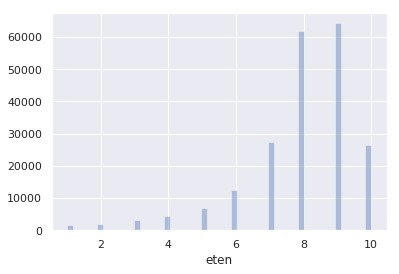

In [9]:
### Overview of the score given
sns.distplot(reviews_NL.eten, kde = False)

In [10]:
### example reviews with bad score
pd.options.display.max_colwidth = 1000
reviews_NL.query('eten < 4').sample(5)[["Review", "eten"]]

,Review,eten
144564,"Wat een drama, dat Maz Mez. Hebben er gegeten met een Groupon-deal. Maar goed dat er voor de deur een supermarkt zit die ’s avonds open is, want daar hebben we snel nog even wat te eten gehaald omdat we nog steeds honger hadden. We voelen ons echt zwaar afgezet met deze deal. Honderd euro waard? Ja, wel als je dan per persoon 10 tapas mag bestellen (zoals bij elk normaal tapasrestaurant), of in elk geval 10 tapas van voldoende grootte krijgt. Maar 1 inktvisringetje per persoon noem ik dus geen tapas. En een half geitenkaaskroketje p.p. ook niet. Of vier minuscule schijfjes stokbrood om de ‘aioli’ in te dopen (een substantie die trouwens weinig met echte aioli te maken had). Of patatas bravas met een soort tomatenpuree? Wij gaan voortaan toch maar weer naar een tapasrestaurant met minder pretenties waar je wel waar voor je geld krijgt.",2.0
110089,"Het eten was van slechte kwaliteit, salade zonder dressing, fish ribs and wings hield in: klein stukje spare rib wat erg droog was, 3 garnalen(die wel smaakten) en 2 kipvleugeltjes die flauw waren. Toetje pancake met bosvruchten dressing???? Geen bosvruchten dressing te zien, wel een rode streep over het bord, maar dat smaakte melig/zout/onbestendig. Dame Blanche leek van oud vanille ijs. Koffie was zo bitter dat heb ik nog nooit meegemaakt. De droge huiswijn smaakte naar bier, de zoete was wel te drinken. Ze hadden waarschijnlijk personeelstekort want na 1 uur hadden we nog niet eens een voorgerecht, laat staan stukje brood gehad. We gaan regelmatig uit eten, maar dit was wel het slechtste wat we meegemaakt hebben. Ook geen gezellig restaurant om binnen te zitten, grote ruimte met bar.",2.0
65115,"Zeer onvriendelijke eigenaar. Prijs kwaliteit buiten proporties, 9,50 voor 5 garnalen? Er mag meer niet dan wel. De klant Is niet welkom en al helemaal niet koning.",2.0
31339,Als vegetariër hier Niet eten een drie Luik ik vette noedels en loempia waarvan ze weigeren toe te geven dat het er niet uitzag (en smaak was nog slechter) de Quick was oké maar omdat de rest zo slecht was ook daar niet van genoten,1.0
140998,"Helaas geen goede ervaring. Eten is welliswaar betaalbaar, maar van zeer matige kwaliteit. Draadjesvlees leek uit een kant en klaar groothandel bakje, veel stukken vet, amper een half champignonnetje in de ''saus''. Partner had een smakeloze kipsate waar ook de nodige stukken vet nog aanzaten. Frites qua smaak ook beneden peil. Helaas een verslechtering tov de vorige eigenaar. Hier komen we niet meer terug.",3.0


## Preparing text for further analysis

In [34]:
reviews_nl = pd.read_pickle("reviews_NL.pck")

### count the number of words per review

In [4]:
%%time
### get the number of words per review
reviews_nl = (
    reviews_nl
    .assign(
        n_words = reviews_nl.Review.apply(lambda x : len(re.findall(r'\w+', x)))
    )
)

CPU times: user 4.61 s, sys: 31.2 ms, total: 4.64 s
Wall time: 4.46 s


#### Distribution of the food ('eten') score gven by reviewers and the relation with the numebr of words

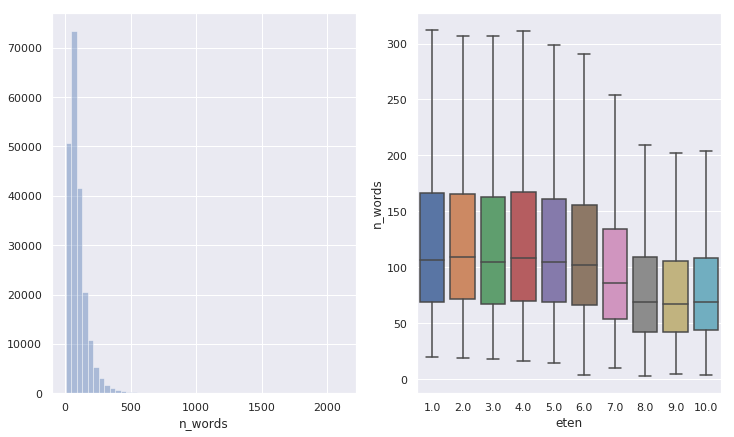

In [5]:
fig, axes = plt.subplots(1,2,  figsize=(12,7))

sns.distplot(reviews_nl.n_words, kde=False, ax=axes[0])
sns.boxplot(y = "n_words", x = "eten", data = reviews_nl, showfliers=False, ax=axes[1])

seems that people who give lower scores ( eten <7) tend to use more words to write the review

/home/longhowlam/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:146: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


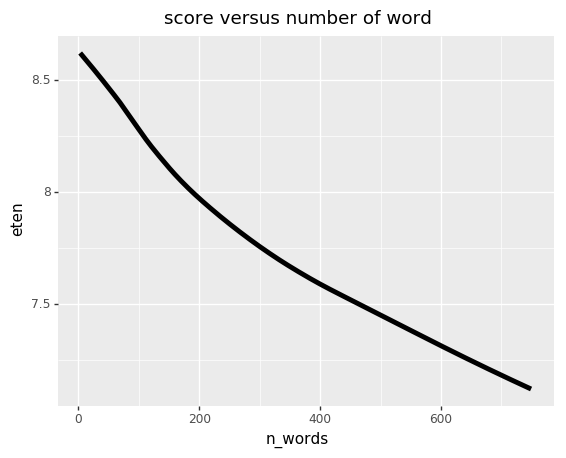

<ggplot: (-9223363266091101103)>

In [45]:
(
    ggplot(reviews_nl.query('n_words < 750'), aes('n_words', 'eten' )) 
    + stat_smooth(method='lowess', size = 2)
    + ggtitle("score versus number of word")
)

### remove stop words and punctuation

In [36]:
def clean_review(x):
    doc = nlp(x)
    tokens = [token.text for token in doc if (not token.is_punct) & (not token.is_stop)]
    return " ".join(tokens)

In [37]:
clean_review(reviews_nl.iloc[3,2])

"Wat weer mee?Goede cijfers Iens app schrijvende komt weer proest humoristische verbazing boven Dit leuke poging restaurant goed opgeleid personeel heel erg best doet maaltijd ternauwernood volstaat prijs Matias zit drukke straat heel restaurantjes proppers staan deur Dit onze 2e keus moesten lang wachten onze 1e keus spareribs cocktails Toen aankwamen hele leuke dag Rijksmuseum zaten uitsluitend toeristen binnen De groep Amerikaanse jongeren korting bakkeleien waarmee blijkbaar geadverteerd buiten Dit restaurantje groot tafel 10 Het personeel telde 6 8 mensen telde snel Er hingen beetje rond Wel heel vriendelijk overigens De maaltijden Mexicaans Oosterse invloeden Margarita 's goed verhoudingsgewijs duur Enchilada 's Fajitas pollo beide bord vol eten aardig smaakvol weinig inspiratie beter zeg hehe).We verwachtten sfeervolle Caribische muziek helaas De radio stond lekker handig nieuws hebt gemist Een grinnik moeilijk onderdrukken In geluidsinstallatie mogen investeren klonk muziek str

In [38]:
%%time
review_sample = reviews_nl.sample(20000)
review_sample = (
    review_sample
    .assign(
        cleaned_review = review_sample.Review.apply(clean_review)
    )
)  

CPU times: user 23min 7s, sys: 30.6 s, total: 23min 38s
Wall time: 5min 56s


In [39]:
review_sample.to_pickle("reviews_NL2.pck")

In [2]:
review_sample = pd.read_pickle("reviews_NL2.pck")

In [40]:
pd.options.display.max_colwidth = 1000
review_sample[["Review", "cleaned_review"]].sample(3)

,Review,cleaned_review
155503,"Alweer enkele weken geleden dat wij, gezin met zoon van 10 jaar daar gegeten hebben. Eindelijk tijd voor een recensie. Zo een leuke locatie, op die hoogte van 32 meter, de wandeling er naar toe is al leuk.Met het zicht op de open keuken was het voor onze zoon ook heel aantrekkelijk, genoeg te zien, koks die geconcentreerd aan het werken zijn.Voor kinderen ook volop keus van de kaart.Prachtig menu, heerlijke huiswijn. De bediening is vriendelijk en behulpzaam. Wat later nog een kijkje genomen op het dakterras, prachtig om al die lichtjes te zien van Veghel en omgeving. Zeker een aanrader en wij komen weer graag een keer terug!",Alweer enkele weken geleden gezin zoon 10 jaar gegeten Eindelijk tijd recensie Zo leuke locatie hoogte 32 meter wandeling toe leuk Met zicht open keuken onze zoon heel aantrekkelijk genoeg zien koks geconcentreerd werken Voor kinderen volop keus kaart Prachtig menu heerlijke huiswijn De bediening vriendelijk behulpzaam Wat later kijkje genomen dakterras prachtig lichtjes zien Veghel omgeving Zeker aanrader komen weer graag keer terug
134041,"Getipt door vrienden. Heerlijk gegeten! Het is een Grillrestaurant van niveau. De ambities zijn merkbaar aanwezig, mooie inrichting en zeer uitdagende kaart. De kids hadden een eigen kinderkaart en er is van alles voor ze te doen. Fijne locatie ook. We konden de auto gratis laten staan en zijn na het eten in 5 minuten naar de bioscoop in het centrum gelopen. De bediening moest nog wat wennen, want het restaurant is net open. Alles bij elkaar een echte aanrader!",Getipt vrienden Heerlijk gegeten Het Grillrestaurant niveau De ambities merkbaar aanwezig mooie inrichting zeer uitdagende kaart De kids hadden eigen kinderkaart Fijne locatie We konden auto gratis laten staan eten 5 minuten bioscoop centrum gelopen De bediening moest wennen restaurant net open Alles elkaar echte aanrader
98922,"Wij hebben hier al vaker gegeten. Nu met een groupondeal. Vooraf hebben we extra brood besteld met aoli en olijfolie. Enige jammere was dat het brood niet warm was. Daarna carpaccio wat prima was. Vervolgens ossenhaaspuntjes met gamba's. Heerlijk!! Als desert boerenjongensijs. Erg lekker. Leuke bediening. Kortom, we komen ook zonder groupon nogmaals eten.",Wij vaker gegeten Nu groupondeal Vooraf extra brood besteld aoli olijfolie Enige jammere brood warm Daarna carpaccio prima Vervolgens ossenhaaspuntjes gamba 's Heerlijk Als desert boerenjongensijs Erg lekker Leuke bediening Kortom komen groupon nogmaals eten


## Classification 

Use predictive models to see what words predict low scores and what words predict high scores

### Define target and Count vectorizer

In [89]:
###  take the bad and good reviews
review_sample_modeling = (
    review_sample
    .query('eten < 5 | eten > 8')
)

### create binary target, bad if review score is < 6 and review score > 8
review_sample_modeling = review_sample_modeling.assign(target = np.where(review_sample_modeling.eten < 6,1,0))

In [90]:
review_sample_modeling.target.value_counts()

0    8507
1    1067
Name: target, dtype: int64

In [92]:
cv = CountVectorizer(ngram_range=(1,2))
cv.fit(review_sample_modeling.cleaned_review)
X = cv.transform(review_sample_modeling.cleaned_review)
target = review_sample_modeling.target

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

In [93]:
X_train.shape

(7180, 336228)

### Logistic regression

In [94]:
for c in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print (
        "Accuracy for C=%s: %s" 
        % (c, accuracy_score(y_val, lr.predict(X_val)))
    )

/home/longhowlam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.9486215538847118
Accuracy for C=0.05: 0.9670008354218881
Accuracy for C=0.25: 0.9736842105263158
Accuracy for C=0.5: 0.9741019214703425
Accuracy for C=0.75: 0.9741019214703425
Accuracy for C=0.95: 0.9736842105263158
Accuracy for C=1: 0.9732664995822891


In [95]:
final_model = LogisticRegression(C=0.5)
final_model.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Look at top words that are distinguishes bad reviews and good reviews
Extract coefficient estimate from the logistic regression and see the biggest and smallest coefficients

In [96]:
#### The best and worst words......
wordcoef = pd.DataFrame({
    "word": cv.get_feature_names(),
    "coef":  final_model.coef_[0]
})

print("Number of coefficients", wordcoef.shape)
print("Number of nonzero coefficients", wordcoef.query('(coef < 0) | (coef > 0)'). shape)

wordcoef.sort_values(by="coef", inplace = True)

Number of coefficients (336228, 2)
Number of nonzero coefficients (266953, 2)


In [100]:
wordcoef.head(15)

,word,coef
126053,heerlijk,-1.666407
127102,heerlijke,-1.279226
274669,top,-0.964211
5005,aanrader,-0.924667
281063,uitstekend,-0.873853
261997,super,-0.867055
303958,voortreffelijk,-0.753240
218004,perfect,-0.743213
111095,geweldig,-0.723247
115786,goed,-0.714108


In [99]:
wordcoef.tail(15)

,word,coef
294623,vet,0.703839
69164,echter,0.719916
315404,weinig,0.757846
267052,teleurstellend,0.758668
263269,taai,0.818753
66090,droog,0.832593
144468,jammer,0.857114
251058,smakeloos,0.878435
267104,teleurstelling,0.881275
161779,koud,0.903279


### Xgboost

An alternative for logistic regression is xgboost and then to look at variable importances

In [81]:
dtrain = xgb.DMatrix(
    X_train, 
    label = y_train, 
    feature_names=cv.get_feature_names()
)
dtest = xgb.DMatrix(
    X_val, 
    label = y_val,
    feature_names=cv.get_feature_names()
)

param = {
    'max_depth':5,
    'objective':'binary:logistic'
}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 50
word_xgb_model = xgb.train(param, dtrain, num_round) #, watchlist)

/home/longhowlam/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


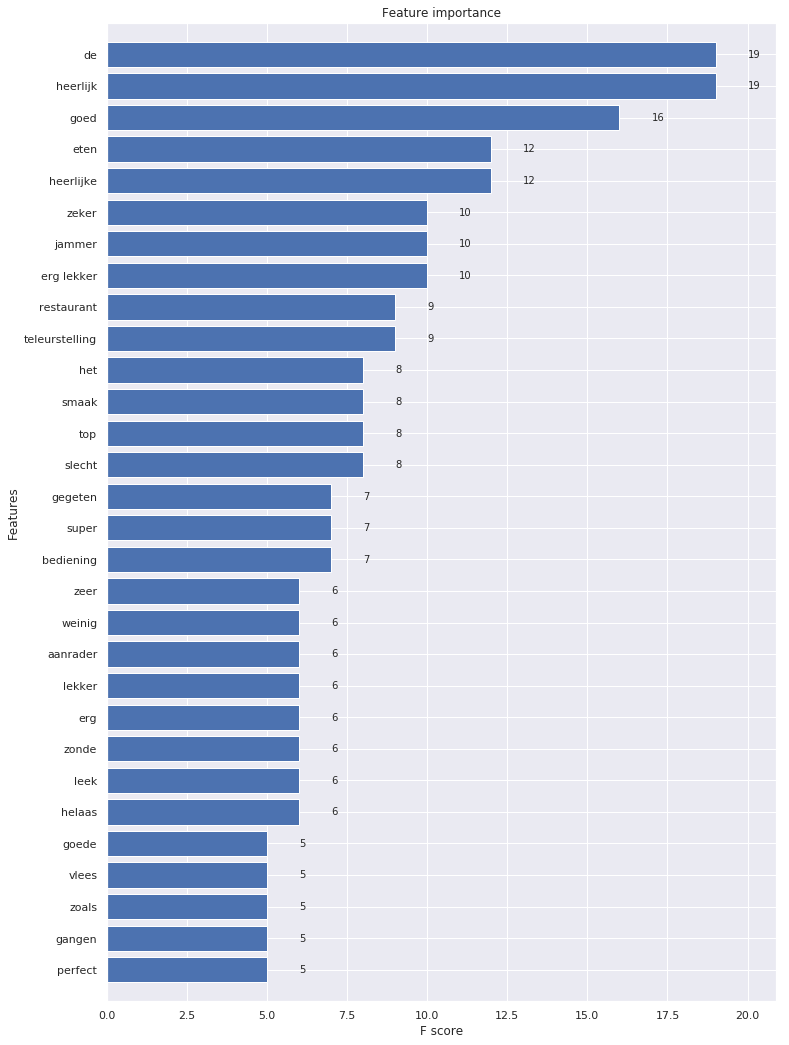

In [82]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(word_xgb_model, max_num_features=30, height=0.8, ax=ax)
plt.show()

## Word clouds

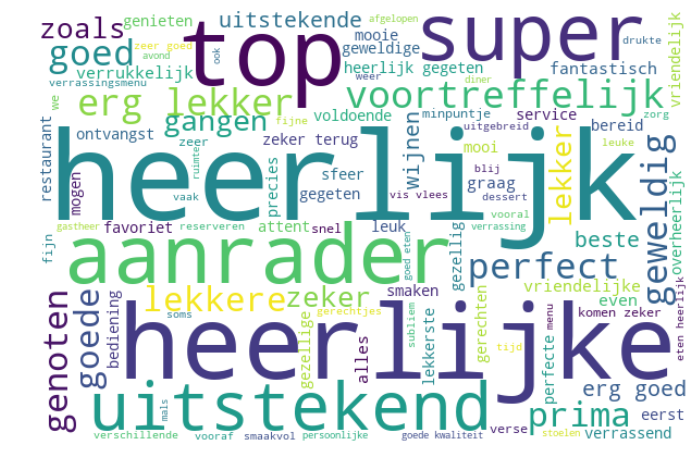

In [83]:
tmp = wordcoef.head(100)
tmp = tmp.assign(freq = -1*tmp.coef)
zz = tmp.set_index('word')["freq"].T.to_dict()

# Create and generate a word cloud image:
tmp = {"A":9, "B":0.10}
wordcloud = WordCloud( background_color="white", height=400, width=600).generate_from_frequencies(zz)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

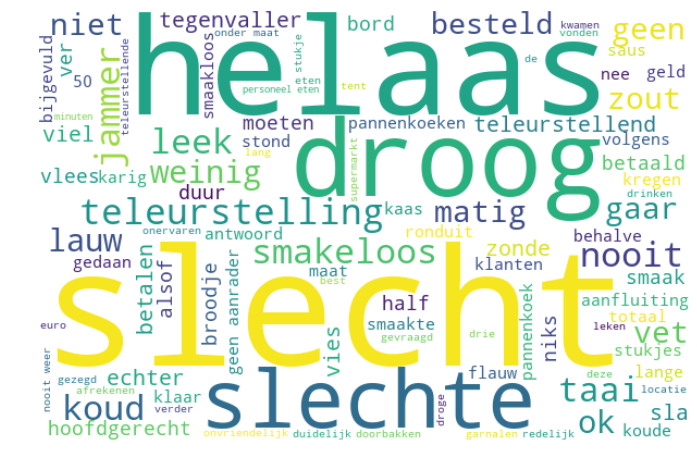

In [84]:
tmp = wordcoef.tail(100)
tmp = tmp.assign(freq = tmp.coef)
zz = tmp.set_index('word')["freq"].T.to_dict()

# Create and generate a word cloud image:
tmp = {"A":9, "B":0.10}
wordcloud = WordCloud( background_color="white", height=400, width=600).generate_from_frequencies(zz)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Topic modeling

Using the package `gensim` to find the topic in the reviews

### Tokenize the reviews

In [9]:
from pprint import pprint
from collections import defaultdict

# remove common words and tokenize
nlstop = spacy.lang.nl.stop_words.STOP_WORDS
texts = [
    [word for word in document.lower().split() if word not in nlstop]
    for document in review_sample.cleaned_review
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

### Create dictionary and corpus

In [11]:
dictionary = corpora.Dictionary(texts)
dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]

Dictionary(23265 unique tokens: ['27,50', 'bediening', 'beter', 'dessert', 'druk']...)


### Train LDA model

In [19]:
review_lda = LdaModel(corpus, num_topics = 10, id2word = dictionary)

In [22]:
review_lda_topics = review_lda.print_topics(num_topics=10 )
review_lda_topics

[(0,
  '0.012*"hadden" + 0.012*"eten" + 0.010*"tafel" + 0.009*"kwam" + 0.009*"wachten" + 0.008*"kregen" + 0.007*"onze" + 0.007*"2" + 0.007*"lang" + 0.006*"uur"'),
 (1,
  '0.013*"high" + 0.012*"tea" + 0.012*"bediening" + 0.012*"eten" + 0.009*"zeer" + 0.007*"weer" + 0.007*"echt" + 0.007*"terras" + 0.006*"leuke" + 0.005*"locatie"'),
 (2,
  '0.008*"eten" + 0.006*"restaurant" + 0.006*"gerechten" + 0.005*"kleine" + 0.005*"uur" + 0.004*"waar" + 0.004*"bediening" + 0.004*"alleen" + 0.004*"glas" + 0.004*"weinig"'),
 (3,
  '0.013*"goed" + 0.012*"bediening" + 0.012*"heerlijk" + 0.012*"zeer" + 0.011*"restaurant" + 0.008*"zeker" + 0.008*"gerechten" + 0.008*"heerlijke" + 0.008*"eten" + 0.008*"avond"'),
 (4,
  '0.024*"eten" + 0.015*"goed" + 0.015*"erg" + 0.013*"bediening" + 0.013*"restaurant" + 0.010*"prima" + 0.009*"lekker" + 0.009*"gegeten" + 0.008*"prijs" + 0.007*"keer"'),
 (5,
  '0.016*"goed" + 0.013*"erg" + 0.011*"eten" + 0.011*"lekker" + 0.010*"heel" + 0.009*"smaak" + 0.008*"bediening" + 0.007*

In [26]:
#pyLDAvis.enable_notebook()
#pyLDAvis.gensim.prepare(review_lda, corpus, dictionary)